# Time series differentiation

## Introduction

Time series differentiation involves computing the differences between consecutive observations in the time series. When it comes to training forecasting models, differentiation offers the advantage of focusing on relative rates of change rather than directly attempting to model the absolute values. Once the predictions have been estimated, this transformation can be easily reversed to restore the values to their original scale.

This methodology is very useful when dealing with time series that exhibit trends, as not all models can capture such trends properly. Among the many machine learning techniques, tree-based models, including decision trees, random forests, and gradient boosting machines (GBMs), stand out for their effectiveness and broad applicability to various domains. However, these models have limitations when it comes to extrapolation. Their inability to project values outside the observed range during training inevitably results in predicted values that deviate from the underlying trend.

Skforecast, version 0.10.0 or higher, introduces a novel `differentiation` parameter within its forecasters. This parameter indicates that a differentiation process must be applied before training the model, and this task is performed through the internal use of a new class named `skforecast.preprocessing.TimeSeriesDifferentiator`. It is important to note that the entire differentiation process is automated and its effects are seamlessly reversed during the prediction phase. This ensures that the resulting forecast values are in the original scale of the time series data.

## TimeSeriesDifferentiator

[TimeSeriesDifferentiator](https://skforecast.org/latest/api/preprocessing) is a custom transformer that follows the preprocessing sklearn API. This means it has the method `fit`, `transform`, `fit_transform` and `reverse_transfor`.

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.preprocessing import TimeSeriesDifferentiator

In [2]:
# Differentiation with TimeSeriesDifferentiator
# ==============================================================================
y = np.array([5, 8, 12, 10, 14, 17, 21, 19], dtype=float)
diffenciator = TimeSeriesDifferentiator()
diffenciator.fit(y)
y_diff = diffenciator.transform(y)

print(f"Original time series   : {y}")
print(f"Differenced time series: {y_diff}")

Original time series   : [ 5.  8. 12. 10. 14. 17. 21. 19.]
Differenced time series: [nan  3.  4. -2.  4.  3.  4. -2.]


The differencing process can be reversed (integration) with the method `inverse_diff()`.

In [3]:
diffenciator.inverse_transform(y_diff)

array([ 5.,  8., 12., 10., 14., 17., 21., 19.])

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>
<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px;">
<p class="title">
    <i class="fa-triangle-exclamation fa" style="font-size: 18px; color:#ff9100;"></i>
    <b style="color: #ff9100;"> &nbsp Warning</b>
</p>

The inverse transformation process <code>inverse_diff()</code> applies only to the same time series that has been previously differentiated using the same <code>TimeSeriesDifferentiator</code> object. This restriction arises from the need to use the initial <i>n</i> values of the time series (<i>n</i> equals the order of differentiation) to effectively undo the differentiation. These values are captured when the <code>fit()</code> method is called.

</div>

<br>

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px;
border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px;">
<p class="title">
    <i class="fa-light fa-pencil fa" style="font-size: 18px; color:#00b8d4;"></i>
    <b> &nbsp Note</b>
</p>

An additional method <code>inverse_transform_next_window</code> is available in <code>TimeSeriesDifferentiator</code>. This method is designed to be used inside the forecasters to reverse the differentiation of the predicted values. If the regressor inside the predictor is trained with a differentiated time series, then its predictions will be too. The <code>inverse_transform_next_window</code> allows the predictions to be returned to the original scale, assuming they follow immediately after the last values observed (<code>last_window</code>).
</div>

## Forecasting with differentiation

In [4]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.preprocessing import TimeSeriesDifferentiator
from sklearn.metrics import mean_absolute_error

Train dates : 1949-01-01 00:00:00 --- 1956-01-01 00:00:00  (n=85)
Test dates  : 1956-01-01 00:00:00 --- 1960-12-01 00:00:00  (n=60)


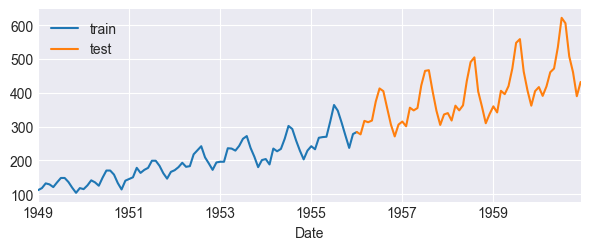

In [5]:
# Download data
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/'
    'master/data/AirPassengers.csv'
)
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m')
data = data.set_index('Date')
data = data.asfreq('MS')
data = data['Passengers']
data = data.sort_index()
data.head(4)

# Data partition train-test
# ==============================================================================
end_train = '1956-01-01'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  " 
    f"(n={len(data.loc[:end_train])})")
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
ax.legend();

Two autoregressive forecasters are created, one with a scikit-learn random forest regressor and the other with an XGBoost. Both are trained on data from 1949-01-01 to 1956-01-01 and produce forecasts for the next 60 months (5 years).

Error (MAE) Random Forest: 69.75
Error (MAE) Gradient Boosting: 62.12


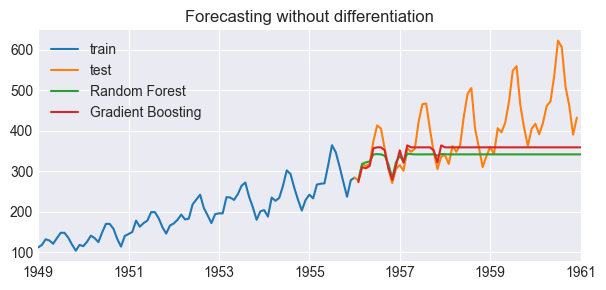

In [6]:
# Forecasting without differentiation
# ==============================================================================
steps = len(data.loc[end_train:])

# Forecasters
forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=963),
                    lags      = 12
                )
forecaster_gb = ForecasterAutoreg(
                    regressor = XGBRegressor(random_state=963),
                    lags      = 12
                )
# Train
forecaster_rf.fit(data.loc[:end_train])
forecaster_gb.fit(data.loc[:end_train])

# Predict
predictions_rf = forecaster_rf.predict(steps=steps)
predictions_gb = forecaster_gb.predict(steps=steps)

# Error
error_rf = mean_absolute_error(data.loc[end_train:], predictions_rf)
error_gb = mean_absolute_error(data.loc[end_train:], predictions_gb)
print(f"Error (MAE) Random Forest: {error_rf:.2f}")
print(f"Error (MAE) Gradient Boosting: {error_gb:.2f}")

# Plot
fig, ax = plt.subplots(figsize=(7, 3), sharex=True, sharey=True)
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions_rf.plot(ax=ax, label='Random Forest')
predictions_gb.plot(ax=ax, label='Gradient Boosting')
ax.set_title(f'Forecasting without differentiation')
ax.set_xlabel('')
ax.legend();

The plot shows that none of the models are able to follow the trend in their predictions. After a few steps, the predictions become almost constant close to the maximum observed in the training data.

Next, two new forecasters are trained using the same configuration, but with the argument `differentiation = 1`. This activates the internal process of differencing (order 1) the time series before training the model, and reverses the differentiation (also known as integration) for the predicted values.

Error (MAE) Random Forest: 39.64
Error (MAE) Gradient Boosting: 55.16


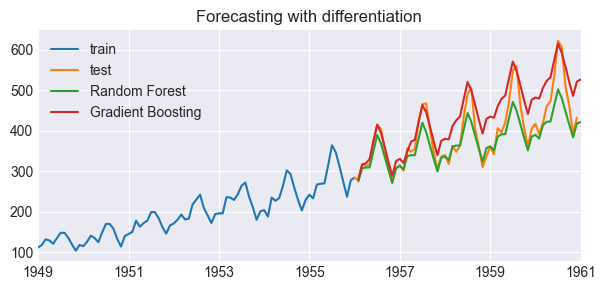

In [7]:
# Forecasting with differentiation
# ==============================================================================
steps = len(data.loc[end_train:])

# Forecasters
forecaster_rf = ForecasterAutoreg(
                    regressor       = RandomForestRegressor(random_state=963),
                    lags            = 12,
                    differentiation = 1
                )
forecaster_gb = ForecasterAutoreg(
                    regressor       = XGBRegressor(random_state=963),
                    lags            = 12,
                    differentiation = 1
                )
# Train
forecaster_rf.fit(data.loc[:end_train])
forecaster_gb.fit(data.loc[:end_train])

# Predict
predictions_rf = forecaster_rf.predict(steps=steps)
predictions_gb = forecaster_gb.predict(steps=steps)

# Error
error_rf = mean_absolute_error(data.loc[end_train:], predictions_rf)
error_gb = mean_absolute_error(data.loc[end_train:], predictions_gb)
print(f"Error (MAE) Random Forest: {error_rf:.2f}")
print(f"Error (MAE) Gradient Boosting: {error_gb:.2f}")

# Plot
fig, ax = plt.subplots(figsize=(7, 3), sharex=True, sharey=True)
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions_rf.plot(ax=ax, label='Random Forest')
predictions_gb.plot(ax=ax, label='Gradient Boosting')
ax.set_title(f'Forecasting with differentiation')
ax.set_xlabel('')
ax.legend();

This time, both models are able to follow the trend in their predictions.

In [8]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>